```
SOW-MKI95 Computer Graphics & Computer Vision Spring 2020
Dr. Umut Güçlü
Lab 14: Generative adversarial networks
12-06-2020
```

```
Group number: 8
Chris Beem: s1044334
Nolan Cardozo: s1034065
Ajinkya Indulkar: s1034517
```

In this lab, you will reimplement the DCGAN from the Gluon tutorial, convert it to a WGAN and compare their results after training them on different datasets.

In [101]:

import os
from datetime import datetime
import time
import logging

import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
from mxnet.optimizer import RMSProp
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### Task 1 (33 points):

Reimplement the DCGAN from the Gluon tutorial in this notebook. You can find the Gluon tutorial [here](https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html).

In [102]:
# set training parameters
epochs = 3
batch_size = 32
latent_z_size = 100
lr = 0.0002
beta1 = 0.5

# set framework device
use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()

#### Load and Preprocess LWF Face Dataset

In [103]:
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
data_path = 'lfw_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with tarfile.open(data_file) as tar:
        tar.extractall(path=data_path)

In [104]:
target_wd = 64
target_ht = 64
img_list = []

def transform(data, target_wd, target_ht):
    # resize to target_wd * target_ht
    data = mx.image.imresize(data, target_wd, target_ht)
    # transpose from (target_wd, target_ht, 3)
    # to (3, target_wd, target_ht)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)

Visualize Images

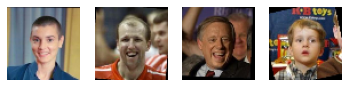

In [105]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 10][0])
plt.show()

#### Define Model

In [106]:
# build the generator
nc = 3
ngf = 64
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 16 x 16
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 32 x 32
    netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

# build the discriminator
ndf = 64
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 64 x 64
    netD.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 32 x 32
    netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 16 x 16
    netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 8 x 8
    netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

#### Train Model

In [107]:
# define loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# define trainer (optimizer) for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

In [108]:
#!pip install --upgrade numpy
#!pip install mxnet-cu100 

import numpy as np
#from mxnet import ndarray as nd
from mxnet import nd, autograd, gluon
import mxnet as mx

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,), ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = batch.data[0].as_in_context(ctx)
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

        with autograd.record():
            # train with real image
            output = netD(data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            # train with fake image
            fake = netG(latent_z)
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(batch.data[0].shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = netG(latent_z)
            output = netD(fake).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch.data[0].shape[0])

        # Print log infomation every ten batches
        if iter % 50 == 0:
            name, acc = metric.get()
            print('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            print('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                       nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()

speed: 3.983908796567286 samples/s
discriminator loss = 1.770899, generator loss = 5.091979, binary training acc = 0.359375 at iter 0 epoch 0
speed: 304.97305821216685 samples/s
discriminator loss = 0.141490, generator loss = 18.364634, binary training acc = 0.924632 at iter 50 epoch 0
speed: 300.8961305653948 samples/s
discriminator loss = 0.097672, generator loss = 6.126165, binary training acc = 0.900371 at iter 100 epoch 0
speed: 292.31272895168985 samples/s
discriminator loss = 0.922104, generator loss = 6.972812, binary training acc = 0.867860 at iter 150 epoch 0
speed: 297.33722936913904 samples/s
discriminator loss = 0.640518, generator loss = 3.676292, binary training acc = 0.854711 at iter 200 epoch 0
speed: 327.38107294608926 samples/s
discriminator loss = 0.251296, generator loss = 6.807886, binary training acc = 0.858005 at iter 250 epoch 0
speed: 287.4626058834238 samples/s
discriminator loss = 0.429994, generator loss = 4.629018, binary training acc = 0.854547 at iter 30

KeyboardInterrupt: ignored

#### Plot Results

In [ ]:
num_image = 8
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    img = netG(latent_z)
    plt.subplot(2,4,i+1)
    visualize(img[0])
plt.show()

In [ ]:
num_image = 12
latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
step = 0.05
for i in range(num_image):
    img = netG(latent_z)
    plt.subplot(3,4,i+1)
    visualize(img[0])
    latent_z += 0.05
plt.show()

### Task 2 (33 points):

Convert the DCGAN to a WGAN.

You can refer to [the WGAN paper](https://arxiv.org/abs/1701.07875) and/or the below notes.

The paper introduces a new loss function for both the discriminator and the generator. Using this loss function instead of binary cross entropy results in a more stable convergence of the GAN.

#### Loss

Let’s compare the binary cross-entropy loss function (the function that that we are currently using to train the discriminator and generator of the DCGAN) to the Wasserstein loss function.

First, the Wasserstein loss requires that we use yi=1 and yi=-1 as labels, rather than 1 and 0. We also remove the sigmoid activation from the final layer of the discriminator, so that predictions pi are no longer constrained to fall in the range [0,1], but instead can now be any number in the range [–∞, ∞]. For this reason, the discriminator in a WGAN is usually referred to as a critic. The Wasserstein loss function is then defined as follows:

$$-\frac{1}{n} \sum_{i=1}^{n}\left(y_{i} p_{i}\right)$$

To train the WGAN critic D, we calculate the loss when comparing predictions for a real images pi=D(xi) to the response yi=1 and predictions for generated images pi=D(G(zi)) to the response yi=-1. Therefore for the WGAN critic, minimizing the loss function can be written as follows:

$$\min _{D}-\left(\mathbb{E}_{x \sim p_{X}}[D(x)]-\mathbb{E}_{z \sim p_{Z}}[D(G(z))]\right)$$

In other words, the WGAN critic tries to maximise the difference between its predictions for real images and generated images, with real images scoring higher. To train the WGAN generator, we calculate the loss when comparing predictions for generated images pi=D(G(zi)) to the response yi=1. Therefore for the WGAN generator, minimizing the loss function can be written as follows:

$$\min _{G}-\left(\mathbb{E}_{z \sim p_{Z}}[D(G(z))]\right)$$

#### Constraints

For the Wasserstein loss function to work, we also need to place an additional constraint on the critic. Specifically, it is required that the critic is a 1-Lipschitz continuous function. Let’s pick this apart to understand what it means in more detail. The critic is a function D that converts an image into a prediction. We say that this function is 1-Lipschitz if it satisfies the following inequality for any two input images, \( x_1 \) and \( x_2 \):

$$ \vert\frac{D(x_1)-D(x_2)\vert}{\vert x_1-x_2\vert}\leq1 $$

Essentially, we require a limit on the rate at which the predictions of the critic can change between two images (i.e., the absolute value of the gradient must be at most 1 everywhere).

It is possible to enforce the Lipschitz constraint by clipping the weights of the critic to lie within a small range, [–0.01, 0.01], after each training batch.

#### Training

When using the Wasserstein loss function, we should train the critic to convergence to ensure that the gradients for the generator update are accurate. This is in contrast to a standard GAN, where it is important not to let the discriminator get too strong, to avoid vanishing gradients.

Therefore, using the Wasserstein loss removes one of the key difficulties of training GANs—how to balance the training of the discriminator and generator. With WGANs, we can simply train the critic several times between generator updates, to ensure it is close to convergence. A typical ratio used is five critic updates to one generator update.

In [109]:
# build the generator
nc = 3
ngf = 64
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 16 x 16
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 32 x 32
    netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

# build the discriminator
ndf = 64
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 64 x 64
    netD.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 32 x 32
    netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 16 x 16
    netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 8 x 8
    netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

In [110]:
# define loss
def wasserstein_loss(y_true, y_pred):
    m_yt = nd.mean(y_true)
    m_yp = nd.mean(y_pred)
    #print(m_yp)
    return m_yt*m_yp
    return -1*mx.ndarray.mean(y_true * y_pred)

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# define trainer (optimizer) for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(),optimizer  =  RMSProp(learning_rate=0.0005))
# implementing clip weights
trainerD = gluon.Trainer(netD.collect_params(),optimizer  = RMSProp(learning_rate=0.0005,clip_weights = 0.01))

speed: 50.4008168209847 samples/s
discriminator loss = -351.715332, generator loss = 202.085419, binary training acc = 0.000000 at iter 0 epoch 0
speed: 96.31270657494966 samples/s
discriminator loss = -1931.880371, generator loss = 964.364868, binary training acc = 0.000000 at iter 50 epoch 0
speed: 98.80647531268635 samples/s
discriminator loss = -1935.921143, generator loss = 966.448425, binary training acc = 0.000000 at iter 100 epoch 0
speed: 93.54031773023944 samples/s
discriminator loss = -1937.224487, generator loss = 966.731445, binary training acc = 0.000000 at iter 150 epoch 0
speed: 93.20843848569488 samples/s
discriminator loss = -1938.354614, generator loss = 967.586304, binary training acc = 0.000000 at iter 200 epoch 0
speed: 93.59687252004535 samples/s
discriminator loss = -1938.181519, generator loss = 967.293091, binary training acc = 0.000000 at iter 250 epoch 0
speed: 96.71188995611791 samples/s
discriminator loss = -1938.013428, generator loss = 967.314331, binary

INFO:root:
binary training acc at epoch 0: facc=0.000000
INFO:root:time: 139.072417


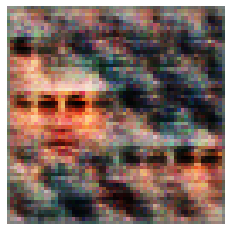

speed: 117.70439053052061 samples/s
discriminator loss = -1938.503662, generator loss = 967.398621, binary training acc = 0.000000 at iter 0 epoch 1
speed: 94.65804748075 samples/s
discriminator loss = -1938.058105, generator loss = 967.834717, binary training acc = 0.000000 at iter 50 epoch 1
speed: 93.93218600035412 samples/s
discriminator loss = -1938.442993, generator loss = 968.112793, binary training acc = 0.000000 at iter 100 epoch 1
speed: 95.43808472104402 samples/s
discriminator loss = -1937.908447, generator loss = 967.511292, binary training acc = 0.000000 at iter 150 epoch 1
speed: 96.94471486344663 samples/s
discriminator loss = -1938.123779, generator loss = 967.457825, binary training acc = 0.000000 at iter 200 epoch 1
speed: 95.17847009826482 samples/s
discriminator loss = -1937.596191, generator loss = 968.022705, binary training acc = 0.000000 at iter 250 epoch 1
speed: 93.65983500740387 samples/s
discriminator loss = -1937.773926, generator loss = 967.828918, binary

INFO:root:
binary training acc at epoch 1: facc=0.000000
INFO:root:time: 139.471184


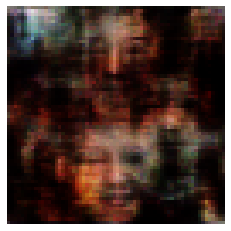

speed: 115.47021485635234 samples/s
discriminator loss = -1936.918579, generator loss = 967.591919, binary training acc = 0.000000 at iter 0 epoch 2
speed: 94.69177242829738 samples/s
discriminator loss = -1937.864380, generator loss = 967.633789, binary training acc = 0.000000 at iter 50 epoch 2
speed: 94.62221185102989 samples/s
discriminator loss = -1938.023560, generator loss = 968.156250, binary training acc = 0.000000 at iter 100 epoch 2
speed: 95.6481752282568 samples/s
discriminator loss = -1938.536255, generator loss = 968.488953, binary training acc = 0.000000 at iter 150 epoch 2
speed: 96.5468751573535 samples/s
discriminator loss = -1937.215820, generator loss = 968.123169, binary training acc = 0.000000 at iter 200 epoch 2
speed: 96.59600064772665 samples/s
discriminator loss = -1938.195801, generator loss = 967.760681, binary training acc = 0.000000 at iter 250 epoch 2
speed: 96.8259620899237 samples/s
discriminator loss = -1938.064209, generator loss = 968.215210, binary

INFO:root:
binary training acc at epoch 2: facc=0.000000
INFO:root:time: 138.666065


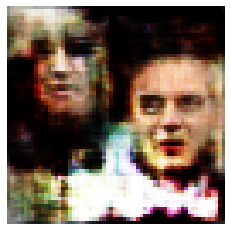

speed: 112.06018055837339 samples/s
discriminator loss = -1938.559692, generator loss = 968.277527, binary training acc = 0.000000 at iter 0 epoch 3
speed: 94.02279506438519 samples/s
discriminator loss = -1938.452881, generator loss = 968.415649, binary training acc = 0.000000 at iter 50 epoch 3
speed: 96.66731103028557 samples/s
discriminator loss = -1938.422119, generator loss = 968.406494, binary training acc = 0.000000 at iter 100 epoch 3
speed: 98.04643660696023 samples/s
discriminator loss = -1937.762573, generator loss = 966.844299, binary training acc = 0.000000 at iter 150 epoch 3
speed: 99.207060362701 samples/s
discriminator loss = -1937.847168, generator loss = 967.585815, binary training acc = 0.000000 at iter 200 epoch 3
speed: 94.85881402565938 samples/s
discriminator loss = -1938.726318, generator loss = 968.634888, binary training acc = 0.000000 at iter 250 epoch 3
speed: 95.83188366889102 samples/s
discriminator loss = -1938.475342, generator loss = 968.354126, binar

INFO:root:
binary training acc at epoch 3: facc=0.000000
INFO:root:time: 138.158113


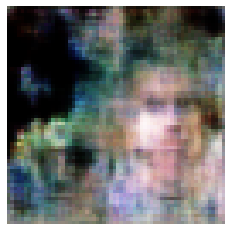

speed: 122.31200021142054 samples/s
discriminator loss = -1937.757324, generator loss = 968.254395, binary training acc = 0.000000 at iter 0 epoch 4
speed: 96.74758271114065 samples/s
discriminator loss = -1937.779541, generator loss = 968.529358, binary training acc = 0.000000 at iter 50 epoch 4
speed: 90.95554270991386 samples/s
discriminator loss = -1938.324951, generator loss = 968.005798, binary training acc = 0.000000 at iter 100 epoch 4
speed: 97.16185011687563 samples/s
discriminator loss = -1937.758911, generator loss = 967.829834, binary training acc = 0.000000 at iter 150 epoch 4
speed: 94.56807614613417 samples/s
discriminator loss = -1937.571533, generator loss = 967.654175, binary training acc = 0.000000 at iter 200 epoch 4
speed: 97.10694823479703 samples/s
discriminator loss = -1938.228027, generator loss = 967.748535, binary training acc = 0.000000 at iter 250 epoch 4
speed: 98.22898528662681 samples/s
discriminator loss = -1938.203369, generator loss = 968.490540, bin

INFO:root:
binary training acc at epoch 4: facc=0.000000
INFO:root:time: 138.468020


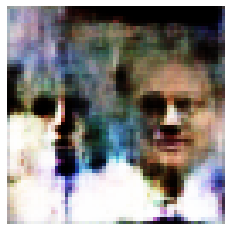

speed: 118.284665299493 samples/s
discriminator loss = -1936.611694, generator loss = 967.928711, binary training acc = 0.000000 at iter 0 epoch 5
speed: 96.97378296637001 samples/s
discriminator loss = -1938.112671, generator loss = 968.169800, binary training acc = 0.000000 at iter 50 epoch 5
speed: 95.62773094395331 samples/s
discriminator loss = -1937.948486, generator loss = 967.671265, binary training acc = 0.000000 at iter 100 epoch 5
speed: 93.86721571501705 samples/s
discriminator loss = -1938.396729, generator loss = 968.465332, binary training acc = 0.000000 at iter 150 epoch 5
speed: 96.3038609733872 samples/s
discriminator loss = -1937.373657, generator loss = 967.991455, binary training acc = 0.000000 at iter 200 epoch 5
speed: 96.12474226287289 samples/s
discriminator loss = -1937.877686, generator loss = 968.039368, binary training acc = 0.000000 at iter 250 epoch 5
speed: 93.27826889504175 samples/s
discriminator loss = -1937.355225, generator loss = 968.159485, binary

INFO:root:
binary training acc at epoch 5: facc=0.000000
INFO:root:time: 138.576564


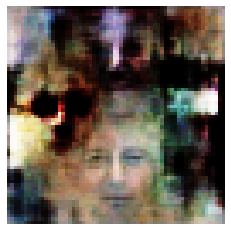

speed: 114.68513007181826 samples/s
discriminator loss = -1937.755127, generator loss = 967.311462, binary training acc = 0.000000 at iter 0 epoch 6
speed: 99.53910138891361 samples/s
discriminator loss = -1937.309692, generator loss = 968.076111, binary training acc = 0.000000 at iter 50 epoch 6
speed: 97.40794677090311 samples/s
discriminator loss = -1938.863647, generator loss = 968.613281, binary training acc = 0.000000 at iter 100 epoch 6
speed: 92.87742767658567 samples/s
discriminator loss = -1938.177734, generator loss = 968.288635, binary training acc = 0.000000 at iter 150 epoch 6
speed: 92.96034608264067 samples/s
discriminator loss = -1937.777954, generator loss = 968.441223, binary training acc = 0.000000 at iter 200 epoch 6
speed: 96.0830414355287 samples/s
discriminator loss = -1938.079346, generator loss = 967.344482, binary training acc = 0.000000 at iter 250 epoch 6
speed: 99.97722727215168 samples/s
discriminator loss = -1937.821289, generator loss = 968.421021, bina

INFO:root:
binary training acc at epoch 6: facc=0.000000
INFO:root:time: 137.391564


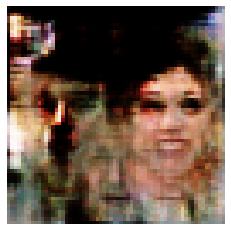

speed: 116.12358347075404 samples/s
discriminator loss = -1937.322998, generator loss = 967.754333, binary training acc = 0.000000 at iter 0 epoch 7
speed: 94.95142199624914 samples/s
discriminator loss = -1936.966064, generator loss = 967.613708, binary training acc = 0.000000 at iter 50 epoch 7
speed: 96.3490735343523 samples/s
discriminator loss = -1937.876709, generator loss = 968.327026, binary training acc = 0.000000 at iter 100 epoch 7
speed: 94.5448940877799 samples/s
discriminator loss = -1937.702026, generator loss = 967.390381, binary training acc = 0.000000 at iter 150 epoch 7
speed: 96.65798252032286 samples/s
discriminator loss = -1937.234009, generator loss = 968.123901, binary training acc = 0.000000 at iter 200 epoch 7
speed: 96.85985177059804 samples/s
discriminator loss = -1938.221069, generator loss = 967.973145, binary training acc = 0.000000 at iter 250 epoch 7
speed: 95.591089409308 samples/s
discriminator loss = -1937.228149, generator loss = 968.103088, binary 

INFO:root:
binary training acc at epoch 7: facc=0.000000
INFO:root:time: 138.450946


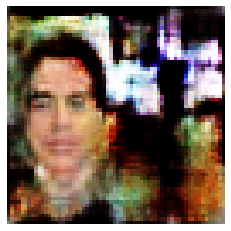

speed: 112.58261440682587 samples/s
discriminator loss = -1937.070801, generator loss = 967.217590, binary training acc = 0.000000 at iter 0 epoch 8
speed: 95.9319559171549 samples/s
discriminator loss = -1937.629028, generator loss = 967.764587, binary training acc = 0.000000 at iter 50 epoch 8
speed: 95.70840033343768 samples/s
discriminator loss = -1938.197754, generator loss = 967.835999, binary training acc = 0.000000 at iter 100 epoch 8
speed: 103.1474475531462 samples/s
discriminator loss = -1938.278320, generator loss = 968.076355, binary training acc = 0.000000 at iter 150 epoch 8
speed: 97.0632679243209 samples/s
discriminator loss = -1937.637695, generator loss = 967.403320, binary training acc = 0.000000 at iter 200 epoch 8
speed: 99.22620290335077 samples/s
discriminator loss = -1937.956543, generator loss = 967.540771, binary training acc = 0.000000 at iter 250 epoch 8
speed: 94.95766947209944 samples/s
discriminator loss = -1937.277344, generator loss = 967.575500, binar

INFO:root:
binary training acc at epoch 8: facc=0.000000
INFO:root:time: 138.411107


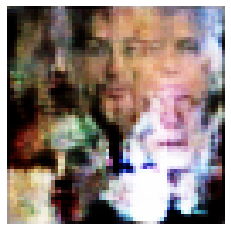

speed: 117.0555164065389 samples/s
discriminator loss = -1937.816406, generator loss = 967.816406, binary training acc = 0.000000 at iter 0 epoch 9
speed: 93.80200746123666 samples/s
discriminator loss = -1936.351807, generator loss = 966.901978, binary training acc = 0.000000 at iter 50 epoch 9
speed: 96.83238882520023 samples/s
discriminator loss = -1938.626465, generator loss = 967.872192, binary training acc = 0.000000 at iter 100 epoch 9
speed: 96.58543479653173 samples/s
discriminator loss = -1937.742432, generator loss = 967.664001, binary training acc = 0.000000 at iter 150 epoch 9
speed: 94.39063701044842 samples/s
discriminator loss = -1937.720703, generator loss = 968.353088, binary training acc = 0.000000 at iter 200 epoch 9
speed: 97.43022028516715 samples/s
discriminator loss = -1938.125244, generator loss = 968.543213, binary training acc = 0.000000 at iter 250 epoch 9
speed: 94.95330287022475 samples/s
discriminator loss = -1937.248535, generator loss = 966.944031, bina

INFO:root:
binary training acc at epoch 9: facc=0.000000
INFO:root:time: 138.284048


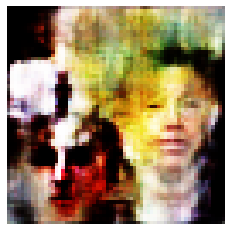

In [111]:
wgan_epochs = 10

real_label = 1000.1*nd.ones((batch_size,), ctx=ctx)
fake_label = -1000.1 * nd.ones((batch_size,), ctx=ctx)
def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(wgan_epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network:
        ###########################
        for iteration in range(5):
            data = batch.data[0].as_in_context(ctx)
            latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)
            with autograd.record():
                # train with real image
                output = netD(data) 
                errD_real = wasserstein_loss(output, real_label)
                metric.update([real_label,], [output,])

                # train with fake image
                fake = netG(latent_z)
                output = netD(fake.detach())
                errD_fake = wasserstein_loss(output, fake_label)
                errD = -1*(errD_real - errD_fake)
                errD.backward()
                metric.update([fake_label,], [output,])
            trainerD.step(batch.data[0].shape[0])

        ############################
        # (2) Update G network: 
        ###########################
        with autograd.record():
            fake = netG(latent_z)
            output = netD(fake)
            #print(real_label)
            errG = (wasserstein_loss(output, real_label))
            errG.backward()

        trainerG.step(batch.data[0].shape[0])

        # Print log infomation every ten batches
        if iter % 50 == 0:
            name, acc = metric.get()
            print('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            print('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                       nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    logging.info('time: %f' % (time.time() - tic))

    #Visualize one generated image for each epoch
    fake_img = fake[0]
    visualize(fake_img)
    plt.show()

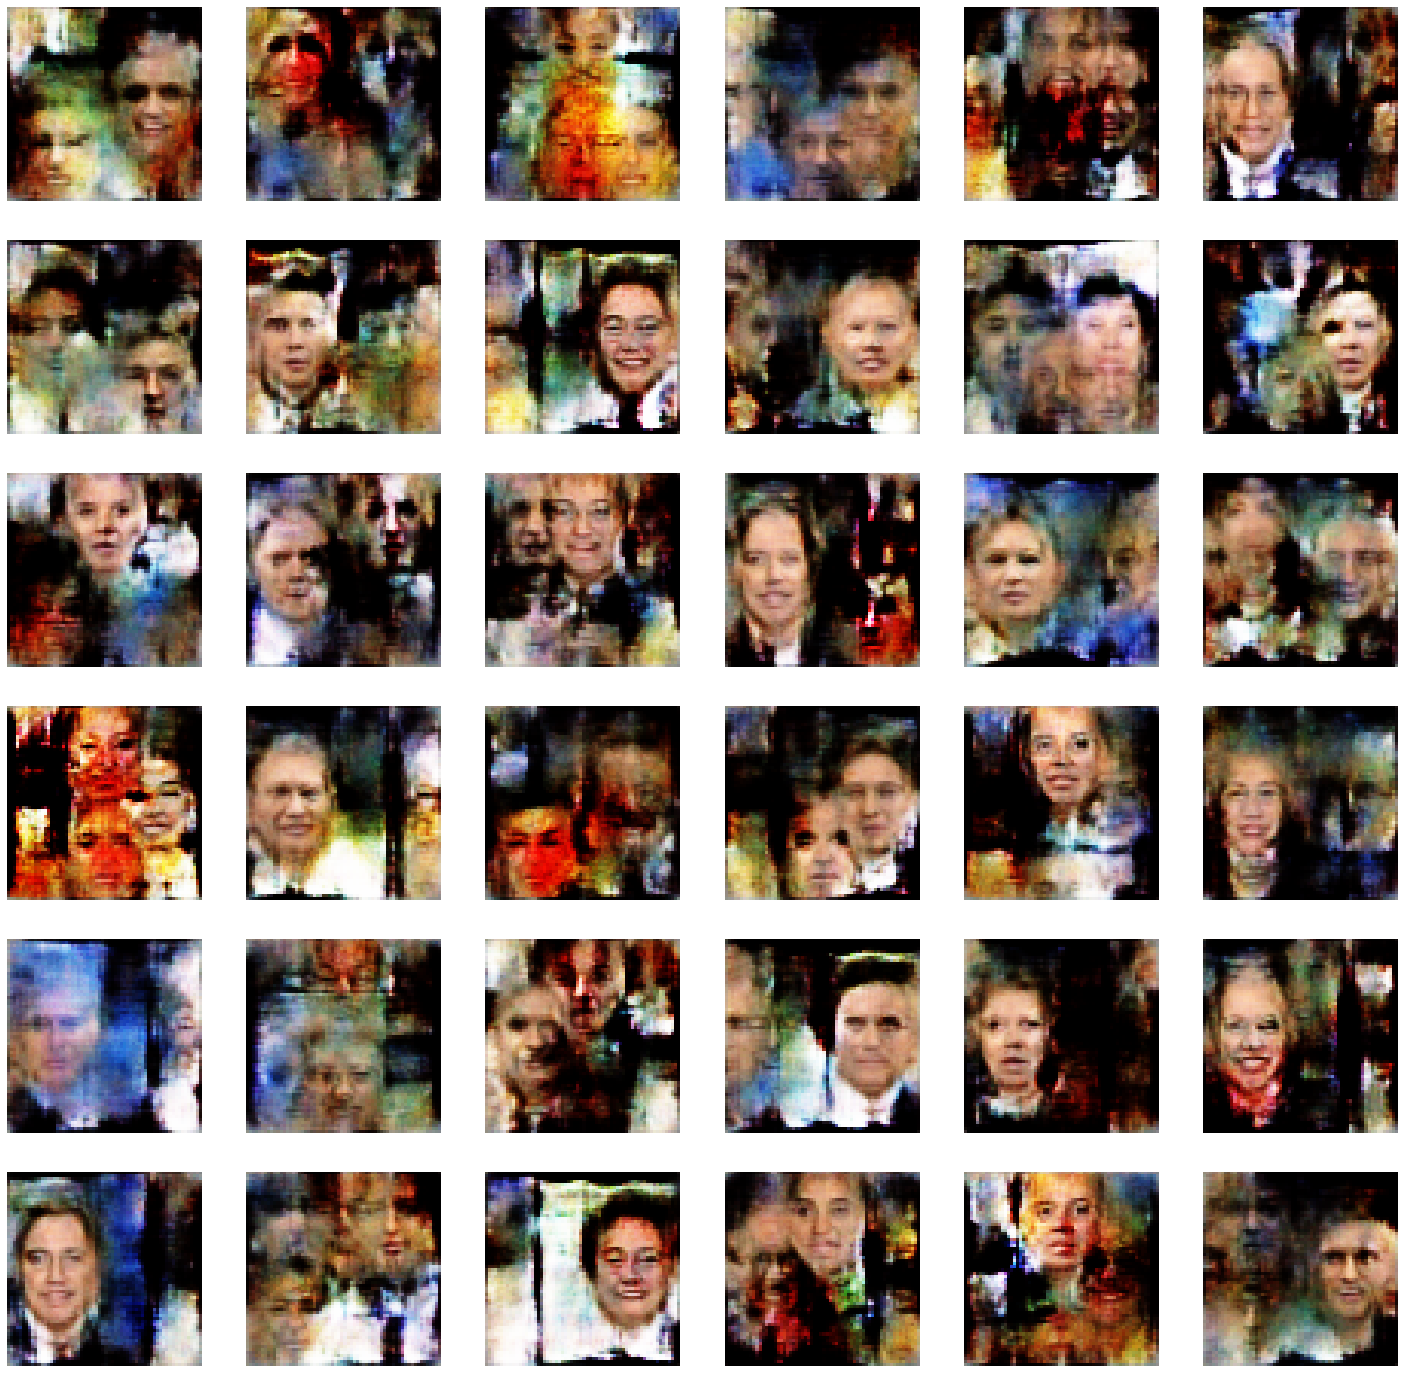

In [138]:

num_image = 36
plt.figure(figsize=(25,25))

for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)*1
    img = netG(latent_z)
    plt.subplot(6,6,i+1)
    visualize(img[0])
    
plt.show()

### Task 3 (33 points):

Compare their results of the DCGAN and the WGAN after training them on different datasets (at least three). You are free to select which datasets to use (it would be easier if you use relatively small datasets). For example, you can use MNIST and Fashion-MNIST datasets (available from Gluon) or anime characters and pokemons datasets (several versions can be found on GitHub).

In [ ]:
batch_size = 128

def transform(data, label):
    return nd.transpose(data.astype(np.float32), (2,0,1))/255, label.astype(np.float32)

img_list = gluon.data.vision.FashionMNIST(train=True,transform = transform)

MNIST_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train=True, transform=transform),batch_size, shuffle=True)
FMNIST_data = gluon.data.DataLoader(gluon.data.vision.FashionMNIST(train=True, transform=transform),batch_size, shuffle=True)


In [ ]:
# build the generator
def gen_wgan_network(colors = 3,filters = 64):
  nc = colors
  ngf = filters
  netG = nn.Sequential()
  with netG.name_scope():
      # input is Z, going into a convolution
      netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
      netG.add(nn.BatchNorm())
      netG.add(nn.Activation('relu'))
      # state size. (ngf*8) x 4 x 4
      netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
      netG.add(nn.BatchNorm())
      netG.add(nn.Activation('relu'))
      # state size. (ngf*8) x 8 x 8
      netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
      netG.add(nn.BatchNorm())
      netG.add(nn.Activation('relu'))
      # state size. (ngf*8) x 16 x 16
      netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
      netG.add(nn.BatchNorm())
      netG.add(nn.Activation('relu'))
      # state size. (ngf*8) x 32 x 32
      netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
      netG.add(nn.Activation('tanh'))
      # state size. (nc) x 64 x 64

  # build the discriminator
  ndf = 64
  netD = nn.Sequential()
  with netD.name_scope():
      # input is (nc) x 64 x 64
      netD.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
      netD.add(nn.LeakyReLU(0.2))
      # state size. (ndf) x 4 x 4
      netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))


  netG.initialize(mx.init.Normal(0.02), ctx=ctx)
  netD.initialize(mx.init.Normal(0.02), ctx=ctx)

  # define trainer (optimizer) for the generator and the discriminator
  trainerG = gluon.Trainer(netG.collect_params(),optimizer  =  RMSProp(learning_rate=0.0005))
  # implementing clip weights
  trainerD = gluon.Trainer(netD.collect_params(),optimizer  = RMSProp(learning_rate=0.0005,clip_weights = 0.01))

  return netG,netD,trainerG,trainerD

In [ ]:
ctx = mx.gpu()

def visualize2(img_arr):

    plt.imshow(((img_arr.asnumpy() + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

for i in range(25):
    plt.subplot(5,5,i+1)
    visualize(img_list[i + 10][0][0])
plt.show()

# define loss
def wasserstein_loss(y_true, y_pred):
    m_yt = nd.mean(y_true)
    m_yp = nd.mean(y_pred)
    #print(m_yp)
    return m_yt*m_yp
    return -1*mx.ndarray.mean(y_true * y_pred)

def train(epochs,dataloader,netG,netD,train_g,train_d):
  epochs = 10

  real_label = 100.1*nd.ones((batch_size,), ctx=ctx)
  fake_label = -100.1 * nd.ones((batch_size,), ctx=ctx)
  def facc(label, pred):
      pred = pred.ravel()
      label = label.ravel()
      return 1
      print(pred,label)


  metric = mx.metric.CustomMetric(facc)

  stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
  logging.basicConfig(level=logging.DEBUG)

  for epoch in range(epochs):
      tic = time.time()
      btic = time.time()
      #dataloader.reset()
      iter = 0
      for batch in dataloader:
          #print("T3:",len(batch[0]))
          batch[0] = batch[0].copyto(ctx)
          ############################
          # (1) Update D network:
          ###########################
          for iteration in range(5):
              data = batch[0]#.data[0].as_in_context(ctx)
              latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)
              with autograd.record():
                  # train with real image
                
                  
                  output = netD(data)

                  
                  
                  errD_real = wasserstein_loss(output, real_label)
                  #print("ODS",len(real_label),len(output))
                  metric.update([real_label,], [output,])
                  
                  # train with fake image
                  fake = netG(latent_z)
                  output = netD(fake.detach())
                  errD_fake = wasserstein_loss(output, fake_label)
                  errD = -1*(errD_real - errD_fake)
                  errD.backward()
                  metric.update([fake_label,], [output,])
                  
              train_d.step(data[0].shape[0])

          ############################
          # (2) Update G network: 
          ###########################
          with autograd.record():
              fake = netG(latent_z)
              output = netD(fake)
              #print(real_label)
              errG = (wasserstein_loss(output, real_label))
              errG.backward()

          train_g.step(data[0].shape[0])

          # Print log infomation every ten batches
          if iter % 50 == 0:
              name, acc = metric.get()
              print('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
              print('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                      %(nd.mean(errD).asscalar(),
                        nd.mean(errG).asscalar(), acc, iter, epoch))
          iter = iter + 1
          btic = time.time()

      name, acc = metric.get()
      metric.reset()
      logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
      logging.info('time: %f' % (time.time() - tic))

      #Visualize one generated image for each epoch
      fake_img = fake[0]
      visualize2(fake_img)
      plt.show()


net_g,net_d,train_g,train_d = gen_wgan_network(colors = 1,filters = 8)

train(10,MNIST_data,net_g,net_d,train_g,train_d)
